In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from glob import glob
import configparser

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

In [3]:
plt.style.use('../figures.mplstyle')

In [1]:
import speclite

[]

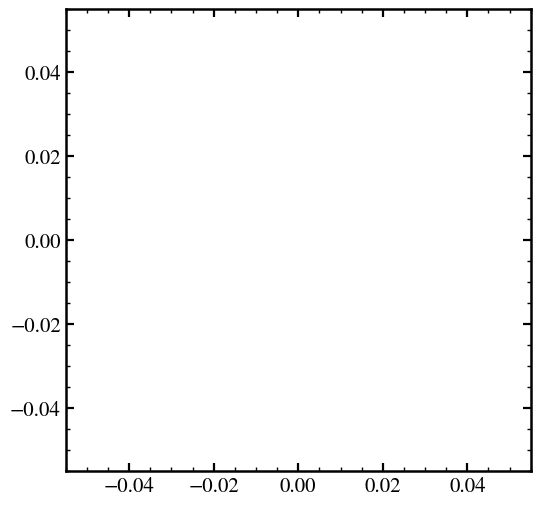

In [41]:
# testfig

plt.figure()
plt.plot()

In [2]:
sdss = speclite.filters.load_filters('sdss2010-*')
speclite.filters.plot_filters(sdss, wavelength_limits=(3000, 11000))

AttributeError: module 'speclite' has no attribute 'filters'

In [5]:
galname = "NGC4030"

In [6]:
fig_out = f"paper-plots/{galname}/"
if not os.path.exists(fig_out):
    os.mkdir(fig_out)

In [6]:
configdir = f"../data/{galname}/config/"

configfils = glob(os.path.join(configdir,"*.ini"))
config_fil = configfils[0]
if len(configfils) > 1:
    for fil in configfils:
        if 'cleaned' in fil:
            config_fil = fil

    
config = configparser.ConfigParser()
parsing = True
while parsing:
    try:
        config.read(config_fil)
        parsing = False
    except configparser.Error as e:
        print(f"Error parsing file: {e}")
        print(f"Cleaning {config_fil}")
        clean_ini_file(config_fil, overwrite=True)


redshift = float(config['default']['z'])
print(f"Redshift z={redshift} found in {config_fil}.")




cubedir = f"../data/{galname}/cube/{galname}-SQUARE0.6/BETA-CORR/"
fitsfils = glob(os.path.join(cubedir,"**","*.fits"),recursive=True)

for fil in fitsfils:
    if "LOGCUBE" in fil:
        cubefil = fil
        print(f"Cube file found: {cubefil}")
    if "MAPS" in fil:
        mapfil = fil
        print(f"Map file found: {mapfil}")

cube = fits.open(cubefil)
Map = fits.open(mapfil)

Redshift z=0.00489 found in ../data/NGC4030/config/mangadap-1-1-LINCUBE-NGC4030.ini.
Map file found: ../data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
Cube file found: ../data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits


In [141]:
binid = cube['BINID'].data[0]

In [144]:
count=0
for ID in np.unique(binid)[1:]:
    w = ID == binid
    if np.sum(w)!=9:
        count+=1
count, len(np.unique(binid))

(411, 11240)

# Whitelight Image

In [37]:
from astropy.stats import sigma_clip

In [103]:
def get_8bit(im, cmin=None, cmax=None, s=4):

    if cmin is None or cmax is None:
        clipped = sigma_clip(im)
        cmin = np.mean(clipped) - s*np.std(clipped)
        cmax = np.mean(clipped) + s*np.std(clipped)
        
    scaledim = 255 * (im - cmin) / (cmax - cmin)
    scaledim[scaledim < 0] = 0
    scaledim[scaledim > 255] = 255

    return scaledim.astype(np.uint8)
    
def make_color_image(cubefil):
    cube = fits.open(cubefil)
    flux = cube['FLUX'].data
    mask = cube['MASK'].data.astype(bool)
    l,y,x = flux.shape
    wave = cube['WAVE'].data

    flux[mask] = 0
    
    B = np.where((wave >= 4000) & (wave <= 5000))[0]
    V = np.where((wave >= 5000) & (wave <= 7000))[0]
    R = np.where((wave >= 5500) & (wave <= 8000))[0]

    Bim = np.sum(flux[B,:,:], axis=0)
    Vim = np.sum(flux[V,:,:], axis=0)
    Rim = np.sum(flux[R,:,:], axis=0)

    Bimg = get_8bit(Bim)
    Vimg = get_8bit(Vim)
    Rimg = get_8bit(Rim)


    color = np.zeros([y,x,3], dtype=np.uint8)
    color[:,:,0] = Rimg
    color[:,:,1] = Vimg
    color[:,:,2] = Bimg

    return color

In [104]:
test = make_color_image(cubefil)

In [115]:
hdu = fits.open("../data/NGC0289/cube/NGC0289-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/100000/0/manga-100000-0-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits")

In [116]:
len(hdu)

13

In [127]:
test = fits.getheader("../data/NGC0289/cube/NGC0289-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/100000/0/manga-100000-0-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits")

In [131]:
from astropy.time import Time

In [134]:
Time([test['DATE-OBS'][:10],'2020-01-01']).min()

<Time object: scale='utc' format='iso' value=2015-10-13 00:00:00.000>

Text(0, 0.5, '$\\Delta \\delta$ (arcsec)')

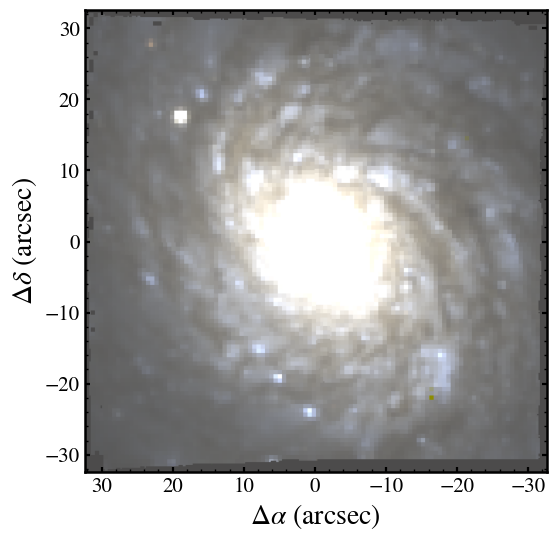

In [105]:
plt.imshow(test,origin='lower', extent=[32.4, -32.6,-32.4, 32.6])
plt.xlabel(r"$\Delta \alpha$ (arcsec)")
plt.ylabel(r"$\Delta \delta$ (arcsec)")

In [9]:
flux = cube['FLUX'].data

In [10]:
whitelight = np.median(flux,axis=0)

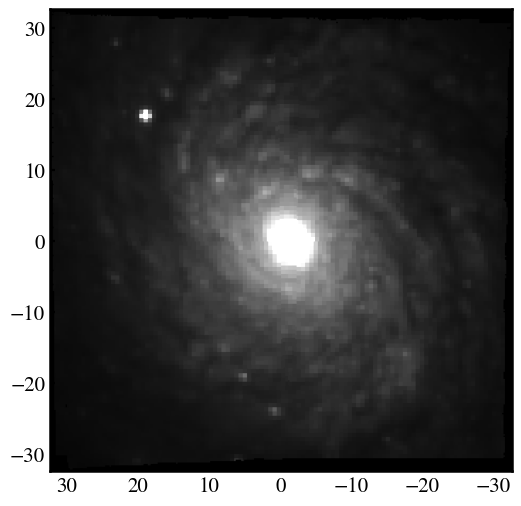

In [11]:
extent = [32.4, -32.6,-32.4, 32.6]

plt.imshow(whitelight,origin='lower',cmap='gray',vmin=0,vmax=np.median(whitelight)+5*np.std(whitelight),
          extent=extent)
#plt.axis('off')
plt.savefig(f"{fig_out}-whitelight.png",bbox_inches='tight',dpi=300)
plt.show()

# Na D ISM EW

In [48]:
binid = cube['BINID'].data[0]
stellar_vel = Map['STELLAR_VEL'].data
waves = cube['WAVE'].data
model = cube['MODEL'].data
ivar = cube['IVAR'].data
flux = cube['FLUX'].data

In [49]:
inds = np.where(binid == 1000)

In [50]:
flux1d = np.median(flux[:,inds[0],inds[1]], axis=1)
ivar1d = np.median(ivar[:,inds[0],inds[1]], axis=1)
model1d = np.median(model[:,inds[0],inds[1]], axis=1)

sv = np.median(stellar_vel[inds[0],inds[1]])
c = 2.998e5
z = ((sv * (1+redshift))/c + redshift)
restwav = waves / (1+z)

In [51]:
sigma1d = 1 / np.sqrt(ivar1d)

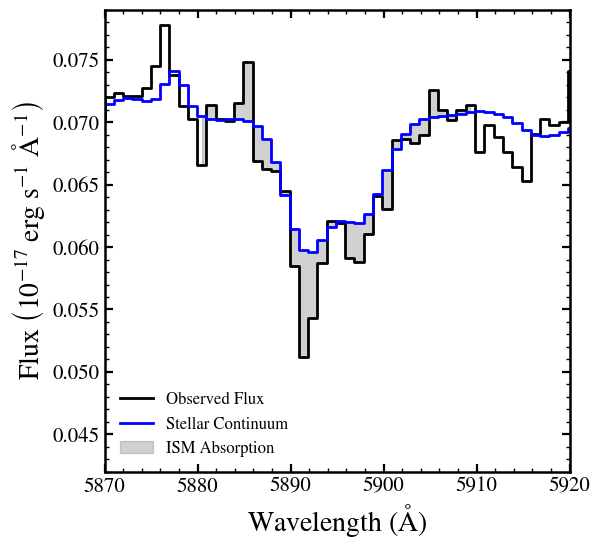

In [52]:
plt.plot(restwav,flux1d,color='k',drawstyle='steps-mid',label="Observed Flux")
plt.plot(restwav,model1d,color='blue',drawstyle='steps-mid',label="Stellar Continuum")
plt.plot(restwav,sigma1d,color='dimgray')

window = (restwav >= 5880) & (restwav <= 5910)

plt.fill_between(restwav,model1d,flux1d, window, color='dimgray', alpha=0.3, step="mid", label='ISM Absorption')

plt.xlim(5870,5920)
plt.ylim(0.042,.079)
plt.legend(frameon=False, fontsize='large')

plt.xlabel(r"Wavelength $\left( \mathrm{\AA} \right)$")
plt.ylabel(r"Flux $\left( \mathrm{10^{-17}\ erg\ s^{-1}\ \AA ^{-1}} \right)$")
#plt.ylabel("Normalized Flux")
plt.savefig(f"{fig_out}-NaD_window.pdf",bbox_inches='tight',dpi=300)
plt.show()

# Dap Maps

In [67]:
configdir = f"../data/{galname}/config/"

configfils = glob(os.path.join(configdir,"*.ini"))
config_fil = configfils[0]
if len(configfils) > 1:
    for fil in configfils:
        if 'cleaned' in fil:
            config_fil = fil

    
config = configparser.ConfigParser()
parsing = True
while parsing:
    try:
        config.read(config_fil)
        parsing = False
    except configparser.Error as e:
        print(f"Error parsing file: {e}")
        print(f"Cleaning {config_fil}")
        clean_ini_file(config_fil, overwrite=True)


redshift = float(config['default']['z'])
print(f"Redshift z={redshift} found in {config_fil}.")




cubedir = f"../data/{galname}/cube/{galname}-SQUARE0.6/BETA-CORR/"
fitsfils = glob(os.path.join(cubedir,"**","*.fits"),recursive=True)

for fil in fitsfils:
    if "LOGCUBE" in fil:
        cubefil = fil
        print(f"Cube file found: {cubefil}")
    if "MAPS" in fil:
        mapfil = fil
        print(f"Map file found: {mapfil}")

cube = fits.open(cubefil)
Map = fits.open(mapfil)

Redshift z=0.00489 found in ../data/NGC4030/config/mangadap-1-1-LINCUBE-NGC4030.ini.
Map file found: ../data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
Cube file found: ../data/NGC4030/cube/NGC4030-SQUARE0.6/BETA-CORR/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits


In [68]:
binid = cube['BINID'].data[0]

flux = cube['FLUX'].data
mask = cube['MASK'].data.astype(bool)
model = cube['MODEL'].data
modmask = cube['MODEL_MASK'].data.astype(bool)

maskcomb = np.logical_or(mask,modmask)

stellar_vel = Map['STELLAR_VEL'].data
stellar_vel_mask = Map['STELLAR_VEL_MASK'].data


stellar_sigma = Map['STELLAR_SIGMA'].data
stellar_sigma_mask = Map['STELLAR_SIGMA_MASK'].data
stellar_sigma_corr = Map['STELLAR_SIGMACORR'].data[0]
stellar_sigma = stellar_sigma - stellar_sigma_corr

chisq = Map['STELLAR_FOM'].data[2]

ivar = cube['IVAR'].data
var = 1/ivar
unc = np.sqrt(var)
SNR = Map['SPX_SNR'].data
ha = Map['EMLINE_GFLUX'].data[23]
ha_mask = Map['EMLINE_GFLUX_MASK'].data[23]

extent = [32.4, -32.6,-32.4, 32.6]

/var/folders/ms/1cj6qz8d54qg6yvchfl0610c0000gt/T/ipykernel_51634/3832300537.py:22: RuntimeWarning: divide by zero encountered in divide
  var = 1/ivar


In [69]:
# whitelight
whitelight = np.median(flux,axis=0)
# stellar velocity
w = (stellar_vel >= np.median(stellar_vel) - 4 * np.std(stellar_vel)) & (stellar_vel <= np.median(stellar_vel) + 4*np.std(stellar_vel))
stellar_vel[~w] = np.nan
w = stellar_vel_mask != 0
stellar_vel[w] = np.nan
# stellar sigma
w = (stellar_sigma >= np.median(stellar_sigma) - 4 * np.std(stellar_sigma)) & (stellar_sigma <= np.median(stellar_sigma) + 4*np.std(stellar_sigma))
stellar_sigma[~w] = np.nan
stellar_sigma[stellar_sigma==0] = np.nan
w = stellar_sigma_mask != 0
stellar_sigma[w] = np.nan
# H alpha
ha[ha==0] = np.nan
w = ha_mask != 0
ha[w] = np.nan

# chisq
chisq[chisq==0] = np.nan
#chisq -= np.min(chisq[np.isfinite(chisq)])

In [70]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

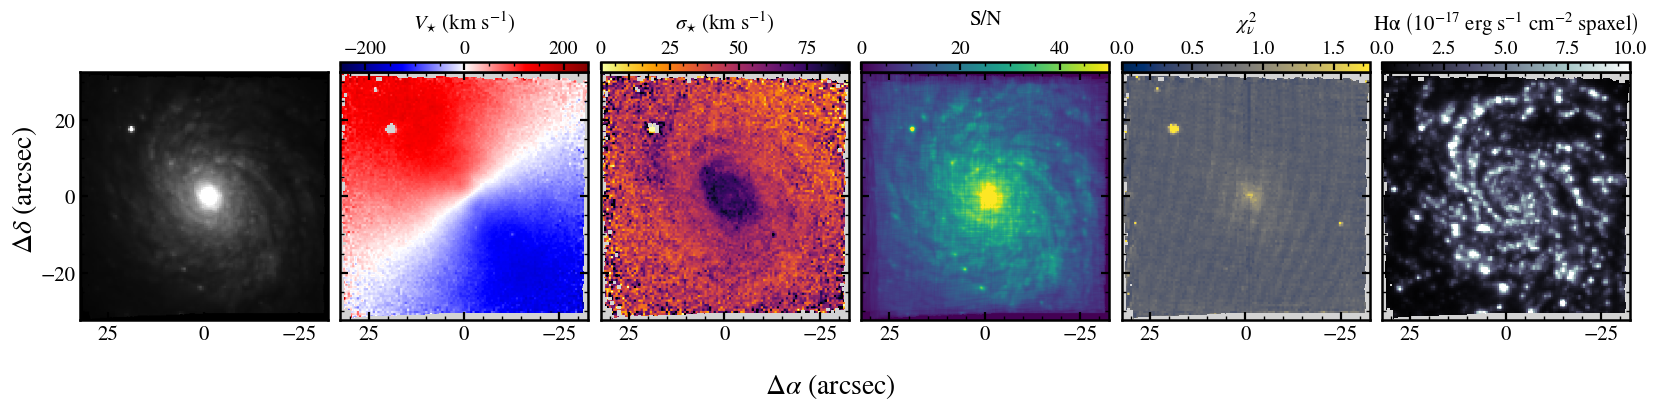

In [78]:
datalist = [whitelight, stellar_vel, stellar_sigma, SNR, chisq, ha]
cmaplist = ['gray','seismic', 'inferno_r', 'viridis', 'cividis', 'bone']
vmin = [0, -250, 0, 0, 0, 0]
vmax = [1, 250, 90, 50, 1.75, 10]
labellist = [None, r"$V_{\star}\ \left( \mathrm{km\ s^{-1}} \right)$", r"$\sigma_{\star}\ \left( \mathrm{km\ s^{-1}} \right)$", 
             "S/N", r"$\chi _{\nu} ^2$", 
             r"$\mathrm{H \alpha}\ \left( \mathrm{10^{-17}\ erg\ s^{-1}\ cm^{-2}\ spaxel} \right) $"]

l = len(datalist)
fig, ax = plt.subplots(1,l,sharey=True,figsize=(20,4))

for i in range(l):
    data = datalist[i]
    cmap = cmaplist[i]
    label = labellist[i]

    im = ax[i].imshow(data, origin='lower', cmap=cmap, extent=extent, vmin=vmin[i], vmax=vmax[i])
    ax[i].set_facecolor('lightgray')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("top", size="4%", pad=0)

    if i==0:
        """transparent_cmap = mcolors.ListedColormap(['none'])
        transparent_norm = mcolors.Normalize(vmin=0, vmax=1)
        
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', cmap=transparent_cmap, norm=transparent_norm)"""
        dummy_data = np.zeros(data.shape)
        dummy_cmap = mcolors.ListedColormap(['none'])  # Invisible color
        dummy_norm = mcolors.Normalize(vmin=0, vmax=1)

        # Create a colorbar with dummy data
        cbar = fig.colorbar(plt.imshow(dummy_data, cmap=dummy_cmap, norm=dummy_norm), cax=cax, orientation='horizontal')

        cbar.ax.set_facecolor('white')
        cbar.set_ticks([])
        cbar.set_label('')
        cbar.outline.set_visible(False)
        cbar.ax.patch.set_alpha(0)
        continue

    else:
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(label,fontsize=15,labelpad=-45)
        cax.xaxis.set_ticks_position('top')

ax[0].set_aspect(1)



fig.text(0.09,0.5,r"$\Delta \delta$ (arcsec)", va="center", rotation='vertical',fontsize=20)
fig.text(0.5,-0.01,r"$\Delta \alpha$ (arcsec)", ha="center",fontsize=20)

fig.subplots_adjust(wspace=0.05)
#plt.savefig(f"{fig_out}-DAPmaps.pdf", bbox_inches='tight',dpi=500)

# galaxy population

In [1]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio

In [2]:
from astropy.io import ascii

In [6]:
sdssfil = "dat/galSpecExtra-dr8.fits"
madfil = "dat/MAD_sample.dat"

mpajhu = fits.open(sdssfil)[1].data
sdssind = (mpajhu['LGM_TOT_P50'] > 5.0) & (mpajhu['SFR_TOT_P50'] > -10.0)

In [7]:
mad = ascii.read(madfil)
madlogMstar = mad['col6']
madlogSFR = np.log10(mad['col7'])

In [8]:
outfil = "paper-plots/fig_sfrM_MAD.pdf"

In [20]:
custcolorscale = [
    [0, 'rgba(255, 255, 255, 0)'],   # Low density: light grey/transparent
    [0.1, 'rgba(240, 240, 240, 0.5)'],
    [0.3, 'rgba(200, 200, 200, 0.7)'],
    [0.6, 'rgba(100, 100, 100, 0.9)'],
    [1, 'rgba(0, 0, 0, 1)']          # High density: dark grey/black
]

In [28]:
x_minor_ticks = np.arange(8.4, 12.1, 0.1)  # Example minor ticks range
y_minor_ticks = np.arange(-2.1, 1.6, 0.1)  # Example minor ticks range

In [37]:
trace1 = go.Histogram2dContour(
    x=mpajhu['LGM_TOT_P50'][sdssind], y=mpajhu['SFR_TOT_P50'][sdssind], name='SDSS (Brinchmann et al. 2004)', ncontours=42,
    colorscale='Greys', reversescale=False, showscale=False
    )

trace3 = go.Scatter(
    x=madlogMstar, y=madlogSFR, mode='markers', name='MUSE Atlas of Disks',
    marker=dict(size=6, color='magenta', symbol='diamond'))

data = [trace1, trace3]


xdict=dict(
            showgrid=True,  # Minor grid lines
            ticklen=3,  # Minor tick length
            tickcolor='black',  # Minor tick color
            tickvals=x_minor_ticks.tolist(),  # Custom minor ticks position
            ticks='inside'  # Ensure minor ticks are inside
        )

ydict =dict(
            showgrid=True,  # Minor grid lines
            ticklen=3,  # Minor tick length
            tickcolor='black',  # Minor tick color
            tickvals=y_minor_ticks.tolist(),  # Custom minor ticks position
            ticks='inside'  # Ensure minor ticks are inside
        )

layout = go.Layout(showlegend=True, autosize=False, width=600, height=550,
                    legend=dict(x=0,y=1,font=dict(size=18, color='black', family='Times New Roman'),bgcolor='rgba(0,0,0,0)'),
                    annotations=[dict(x=0.5, y=-0.15, showarrow=False, text=r'$\log M_{*}/M_{\odot}$', xref='paper', yref='paper',
                                          font=dict(size=40, color='black')),
                                     dict(x=-0.18, y=0.5, showarrow=False, text=r'$\log \mathrm{SFR}/[M_{\odot}\mathrm{yr}^{-1}]$)',
                                              xref='paper', yref='paper', textangle=-90, 
                                              font=dict(size=40, color='black'))],
                   xaxis=dict(range=[8.4,12], domain=[0,1.0],
                              showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror='all',
                              #titlefont=dict(color='black', size=20, family='Times New Roman'),
                              ticks='inside', tickmode='auto', ticklen=6, tickfont=dict(color='black', size=20, family='Times New Roman'),
                             #minor=dict(showgrid=True, ticklen=4, nticks=10)
                              minor=xdict
                             ),
                   yaxis=dict(range=[-2.1,1.5], domain=[0,1.0],
                              showgrid=True, zeroline=True, showline=True, linecolor='black', linewidth=2, mirror='all',
                              #titlefont=dict(color='black', size=20, family='Times New Roman'),
                              ticks='inside', tickmode='auto', ticklen=6, tickfont=dict(color='black', size=20, family='Times New Roman'),
                             #minor=dict(showgrid=True, ticklen=4, nticks=10)
                              minor=ydict
                             )
                  )


fig = go.Figure(data=data, layout=layout)

pio.write_image(fig, outfil)  